In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import re 
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.6.4


In [4]:
A = tf.data.experimental.AUTOTUNE
GP = KaggleDatasets().get_gcs_path()
BS = 16*strategy.num_replicas_in_sync
IS = [180,180]
E = 25

### Load the data

In [5]:
fn = tf.io.gfile.glob(str(GP + '/chest_xray/train/*/*'))
fn.extend(tf.io.gfile.glob(str(GP + '/chest_xray/val/*/*')))

rf, vf = train_test_split(fn, test_size = 0.2)

2022-07-20 06:48:58.009474: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [6]:
cn = len([f for f in rf if 'NORMAL' in f])
cp = len([f for f in rf if 'PNEUMONIA' in f])

print('Normal image count : ',cn)
print('Pneumonia image count : ',cp)

Normal image count :  1076
Pneumonia image count :  3109


In [7]:
rl = tf.data.Dataset.from_tensor_slices(rf)
vl = tf.data.Dataset.from_tensor_slices(vf)

for f in rl.take(5):
    print(f.numpy())

b'gs://kds-df917d29d90ba82a9bf3efc0685a277c92ed430e6538b7ba835b3041/chest_xray/train/PNEUMONIA/person1359_virus_2340.jpeg'
b'gs://kds-df917d29d90ba82a9bf3efc0685a277c92ed430e6538b7ba835b3041/chest_xray/train/PNEUMONIA/person119_virus_225.jpeg'
b'gs://kds-df917d29d90ba82a9bf3efc0685a277c92ed430e6538b7ba835b3041/chest_xray/train/PNEUMONIA/person501_bacteria_2113.jpeg'
b'gs://kds-df917d29d90ba82a9bf3efc0685a277c92ed430e6538b7ba835b3041/chest_xray/train/NORMAL/NORMAL2-IM-0518-0001.jpeg'
b'gs://kds-df917d29d90ba82a9bf3efc0685a277c92ed430e6538b7ba835b3041/chest_xray/train/PNEUMONIA/person1321_bacteria_3359.jpeg'


2022-07-20 06:48:59.224357: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
rc = tf.data.experimental.cardinality(rl).numpy()
vc = tf.data.experimental.cardinality(vl).numpy()

print('Training images count : ',str(rc))
print('Validation images count : ',str(vc))

Training images count :  4185
Validation images count :  1047


In [9]:
cna = np.array([str(tf.strings.split(i, os.path.sep)[-1].numpy())[2:-1]
              for i in tf.io.gfile.glob(str(GP+'/chest_xray/train/*'))])
cna

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [10]:
def get_label(fp):
    p = tf.strings.split(fp,os.path.sep)
    return p[-2] == 'PNEUMONIA'

In [11]:
def decode_img(i):
    i = tf.image.decode_jpeg(i, channels = 3)
    i = tf.image.convert_image_dtype(i, tf.float32)
    return tf.image.resize(i, IS)

In [12]:
def process_path(f):
    l = get_label(f)
    i = tf.io.read_file(f)
    i = decode_img(i)
    return i,l

In [13]:
rd = rl.map(process_path, num_parallel_calls = A)
vd = vl.map(process_path, num_parallel_calls = A)

In [14]:
for image, label in rd.take(3):
    print('Image shape : ',image.numpy().shape)
    print('Label : ',label.numpy())

2022-07-20 06:49:00.905528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Image shape :  (180, 180, 3)
Label :  True
Image shape :  (180, 180, 3)
Label :  True
Image shape :  (180, 180, 3)
Label :  True


In [15]:
el = tf.data.Dataset.list_files(str(GP + '/chest_xray/test/*/*'))
ec = tf.data.experimental.cardinality(el).numpy()
ed = el.map(process_path, num_parallel_calls = A)
ed = ed.batch(BS)

ec

624

### Visualize the dataset

In [16]:
def prepare_for_training(ds, cache = True, sbs = 1000):
    if cache:
        if isinstance(cache,str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size = sbs)
    
    ds = ds.repeat()
    ds = ds.batch(BS)
    ds = ds.prefetch(buffer_size = A)
    
    return ds

In [17]:
rd = prepare_for_training(rd)
vd = prepare_for_training(vd)

ib, lb = next(iter(rd))

2022-07-20 06:49:12.245632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 127 of 1000
2022-07-20 06:49:22.110536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 258 of 1000
2022-07-20 06:49:32.151583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 388 of 1000
2022-07-20 06:49:42.786885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 492 of 1000
2022-07-20 06:49:52.180150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 612 of 1000
2022-07-20 06:50:02.221404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 743 of 1000
2022-07-20 06:50:12.627851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle b

In [18]:
def show_batch(ib, lb):
    plt.figure(figsize = (10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(ib[n])
        if lb[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

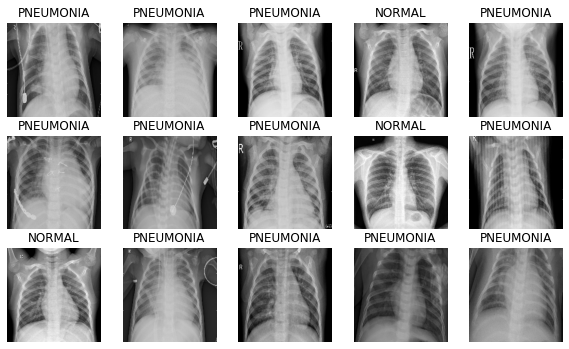

In [19]:
show_batch(ib.numpy(),lb.numpy())

### Build the CNN

In [20]:
def conv_block(f):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConvolution2D(f, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConvolution2D(f, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    return block

In [21]:
def dense_block(u,dr):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(u, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dr)
    ])
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IS[0],IS[1],3)),
        tf.keras.layers.Conv2D(16,3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16,3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512,0.7),
        dense_block(128,0.5),
        dense_block(64,0.3),
        tf.keras.layers.Dense(1, activation = 'sigmoid')])
    
    return model

### Correct the data imbalance

In [23]:
initial_bias = np.log([cp / cn])
initial_bias

array([1.06105067])

In [24]:
w0 = (1/cn)*(rc)/2.0
w1 = (1/cp)*(rc)/2.0

cw = {0:w0, 1:w1}

print('weight for class 0 : {:.2f}'.format(w0))
print('weight for class 1 : {:.2f}'.format(w1))

weight for class 0 : 1.94
weight for class 1 : 0.67


### Train the model

In [25]:
with strategy.scope():
    model = build_model()
    
    M = ['accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')]
    
    model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = M)
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

### Finetune the model

In [26]:
ccb = tf.keras.callbacks.ModelCheckpoint('xray_model.h5', save_best_only = True)
esc = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [27]:
import tensorflow as tf

def edi(lr,s):
    def edf(e):
        return lr*0.1**(e/s)
    return edf

edf = edi(0.01,20)
ls = tf.keras.callbacks.LearningRateScheduler(edf)

In [28]:
history = model.fit(rd,
                   steps_per_epoch = rc//BS,
                   epochs = E,
                   validation_data = vd,
                   validation_steps = vc//BS,
                    class_weight = cw,
                   callbacks = [ccb, esc, ls])

Epoch 1/25


2022-07-20 06:50:39.968850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 146 of 1000
2022-07-20 06:50:49.913454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 296 of 1000
2022-07-20 06:50:59.983351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-07-20 06:51:09.953228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 586 of 1000
2022-07-20 06:51:19.985153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 733 of 1000
2022-07-20 06:51:29.990676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 863 of 1000
2022-07-20 06:51:39.254498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer fille

261/261 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.7720 - precision: 0.9117 - recall: 0.7678

2022-07-20 06:56:25.845681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 136 of 1000
2022-07-20 06:56:36.022467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 278 of 1000
2022-07-20 06:56:45.823459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 415 of 1000
2022-07-20 06:56:55.953021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 553 of 1000
2022-07-20 06:57:05.823248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 692 of 1000
2022-07-20 06:57:15.891159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 833 of 1000
2022-07-20 06:57:25.825670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle b

261/261 [==============================] - 429s 1s/step - loss: 0.4911 - accuracy: 0.7720 - precision: 0.9117 - recall: 0.7678 - val_loss: 0.4474 - val_accuracy: 0.8221 - val_precision: 0.8349 - val_recall: 0.9467
Epoch 2/25
261/261 [==============================] - 76s 290ms/step - loss: 0.2960 - accuracy: 0.8760 - precision: 0.9562 - recall: 0.8729 - val_loss: 0.2893 - val_accuracy: 0.8750 - val_precision: 0.8658 - val_recall: 0.9831
Epoch 3/25
261/261 [==============================] - 76s 292ms/step - loss: 0.2428 - accuracy: 0.9001 - precision: 0.9702 - recall: 0.8930 - val_loss: 0.8039 - val_accuracy: 0.7394 - val_precision: 1.0000 - val_recall: 0.6471
Epoch 4/25
261/261 [==============================] - 76s 290ms/step - loss: 0.2862 - accuracy: 0.8831 - precision: 0.9586 - recall: 0.8807 - val_loss: 0.3084 - val_accuracy: 0.8923 - val_precision: 0.9673 - val_recall: 0.8844
Epoch 5/25
261/261 [==============================] - 76s 290ms/step - loss: 0.2181 - accuracy: 0.9133 - 

### Data Visualization

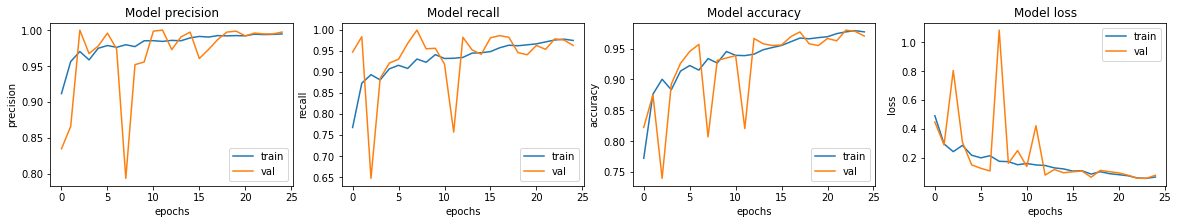

In [29]:
fig, ax = plt.subplots(1,4, figsize = (20,3))
ax = ax.ravel()

for i,met in enumerate(['precision','recall','accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

### Predict and evaluate results

In [30]:
loss, acc, prec, rec = model.evaluate(ed)

39/39 [==============================] - 49s 1s/step - loss: 0.6182 - accuracy: 0.8109 - precision: 0.7753 - recall: 0.9821


In [31]:
print('loss : {:.2f}'.format(loss))
print('accuracy : {:.2f}'.format(acc))
print('precision : {:.2f}'.format(prec))
print('recall : {:.2f}'.format(rec))

loss : 0.62
accuracy : 0.81
precision : 0.78
recall : 0.98
